# Predicción de el dinero de caja

La idea con este pequeño pograma es poder predecir que gastos diaríos se tienen, para poder disponer del el dinero entes que aparezca algún improvisto

Celda para cargar todas las librerias necesarias 

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

import tensorflow as tf
import os

# Lectura de datos

Lectura de la base de datos de compras diarias desde Enero hasta diciembre de 2019

In [77]:
data = pd.read_excel("REPORTE.xlsx")
data

,FECHA,VALOR NETO,IVA,TOTAL
0,2019-01-04,685576,130259,815835
1,2019-01-08,15045,2859,17904
2,2019-01-08,259641,49332,308973
3,2019-01-08,209989,39898,249887
4,2019-01-09,34668,6587,41255
...,...,...,...,...
521,2019-12-26,147705,28064,175769
522,2019-12-27,108840,0,108840
523,2019-12-27,118124,22444,140568
524,2019-12-27,14991629,2848410,17840039


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 4 columns):
FECHA                526 non-null datetime64[ns]
VALOR NETO           526 non-null int64
IVA                  526 non-null int64
TOTAL                526 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 16.6 KB


definicion de variables auxiliares para manejos de Columnas

In [78]:
fecha = data.columns[0]
Valor = data.columns[1]
IVA = data.columns[2]
Total = data.columns[3]

Dado que se tienen listados en diferentes filas los gastos de un mismo día se debe juntar los gastos de un solo día para poder pintar la seria de tiempo correctamente

In [126]:
data_compress = data.groupby(fecha)[[Valor,IVA,Total]].sum()
data_compress

,VALOR NETO,IVA,TOTAL
FECHA,,,
2019-01-04,685576,130259,815835
2019-01-08,484675,92089,576764
2019-01-09,201610,38306,239916
2019-01-10,236406,44916,281322
2019-01-11,153872,29236,183108
...,...,...,...
2019-12-23,215861,26384,242245
2019-12-24,77930,14807,92737
2019-12-26,289725,28064,317789


Hagamos un plot para ver la serie de tiempo con los valores totales de las compras


Text(0, 0.5, 'Dinero')

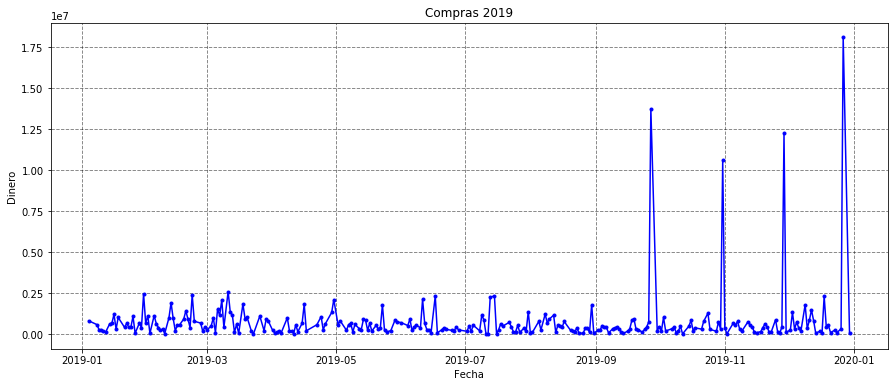

In [94]:
plt.figure(figsize=(15,6))

plt.plot(data_compress[Total],"b-")
plt.plot(data_compress[Total],"b.")
plt.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.9)
plt.title("Compras 2019")
plt.xlabel("Fecha")
plt.ylabel("Dinero")

Ahora se normalizan los datos

Text(0, 0.5, 'Dinero')

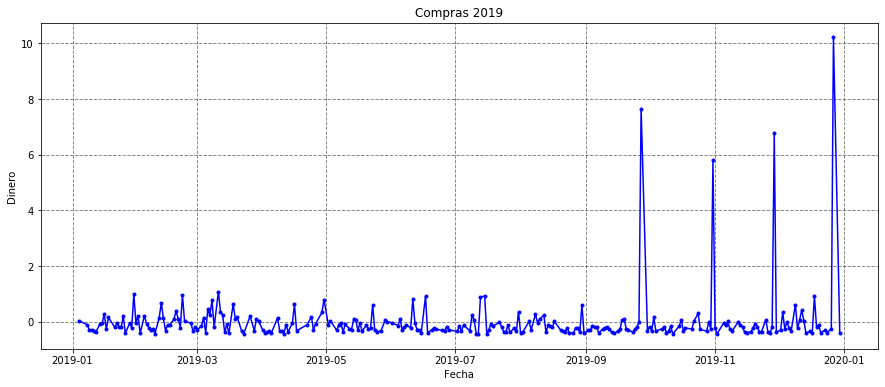

In [107]:
data_mean = data_compress[Total].mean()
data_std = data_compress[Total].std()

data_norm = (data_compress[Total]-data_mean)/data_std

plt.figure(figsize=(15,6))

plt.plot(data_norm,"b-")
plt.plot(data_norm,"b.")
plt.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.9)
plt.title("Compras 2019")
plt.xlabel("Fecha")
plt.ylabel("Dinero")

Ahora se debe dividir los datos en conjuntos de validación y entrenamiento 

In [140]:
x = np.arange(len(data_compress[Total]))
split = int(len(data_compress[Total])*0.7)

time_train = x[:split]
x_train = data_compress[Total][:split]

time_valid = x[split:]
x_valid = data_compress[Total][split:]

Ahora se define una función que crea una ventana en los datos. los valores anteriores podrían verse como las características de entrada. El tamaño de la ventana es uno de tamaño fijo 

In [141]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


Ahora se crea el conjunto de datos de entrenamiento usando la anterior funcion de "ventaneo"

In [158]:
tf.keras.backend.clear_session()
#tf.random.set_seed(51)
#np.random.seed(51)
shuffle_buffer_size = 64
window_size = 8
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)

(190,)


### Creando el modelo 



In [159]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=60, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
tf.keras.layers.LSTM(60, return_sequences=True),
tf.keras.layers.LSTM(60, return_sequences=True),
tf.keras.layers.Dense(30, activation="relu"),
tf.keras.layers.Dense(10, activation="relu"),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 400)])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

Como se puede ver, este modelo consta de una capa de convulución , una capa LSTM y una capa densa.


### Entrenamiento y auste del modelo

In [160]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
 optimizer=optimizer,
 metrics=["mae"])
history = model.fit(train_set,epochs=500)

ValueError: Cannot use the given session to evaluate tensor: the tensor's graph is different from the session's graph.

In [ ]:
# Autocorrelación

La autcorrelación es similar 

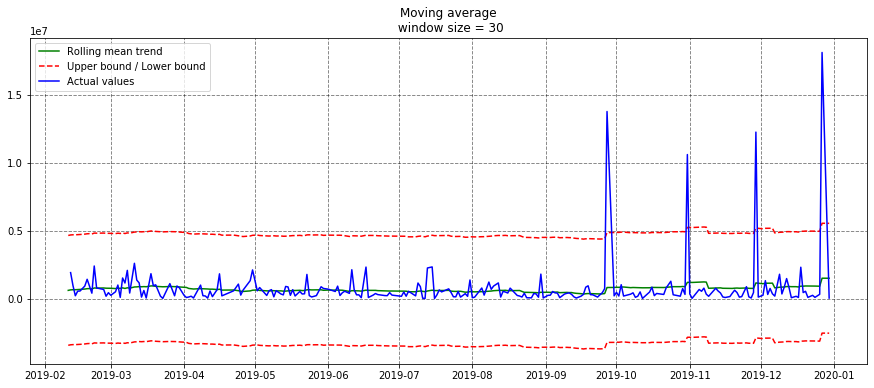

In [99]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,6))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:],"b-", label='Actual values')
    plt.legend(loc='best')
    plt.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.9)


plot_moving_average(data_compress[Total], 30, plot_intervals = True)


### Suavizado exponencial 


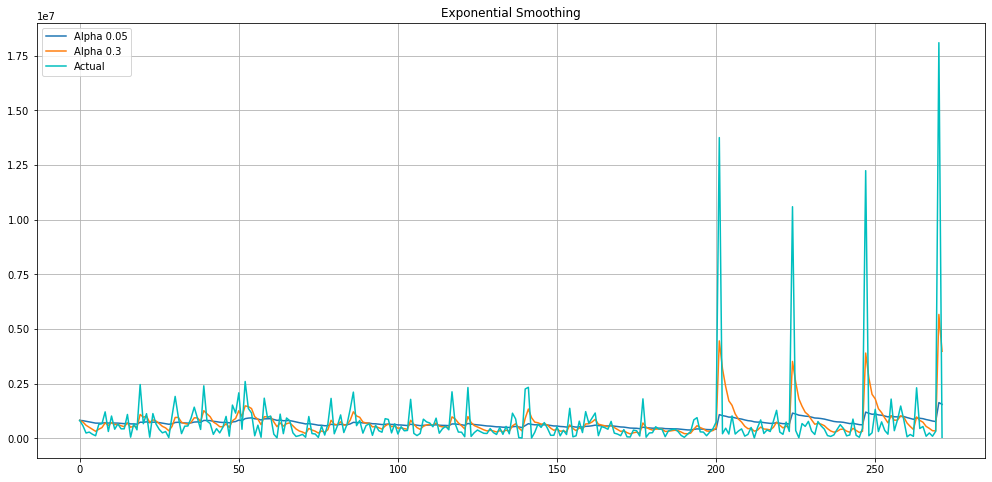

In [100]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data_compress[Total], [0.05, 0.3])